# Examples of object type customization

## Listing techniques per CPT measurement

In [1]:
%matplotlib inline

While performing CPT measurements, different techniques can be used. Since these can have an impact on the results, it can be interesting to download this additional information in order to better comprehend the CPT data.

Different CPT techniques can be applied at various depths, so the easiest way to add this to pydov is to use a new Sondering subtype `Techniek`, as shown below. The result will be that one can then choose to query CPT measurements and either retrieve a dataframe with the measurements themselves, or a dataframe with the techniques applied. The user can subsequently compare or merge the two dataframes at will.

In [2]:
from pydov.types.fields import XmlField, XsdType
from pydov.types.abstract import AbstractDovSubType
from pydov.types.sondering import Sondering

A new subtype has to be a subclass of the AbstractDovSubType class and implement two class variables: rootpath and fields.

The `rootpath` is the XML XPath expression matching all instances of this subtype in the XML. One instance of this subtype will be created for each element matched by the `rootpath` XPath expression.

In the `fields` all the fields of this subtype are listed. These are instances of `XmlField` and should have at minimum a `name`, a `source_xpath` and a `datatype`. Additionally, a field should have a `definition` and can have a reference to an XSD schema type. The latter will be resolved and parsed at runtime, resulting in a list of values of this field.

In [3]:
class Techniek(AbstractDovSubType):
    
    rootpath = './/sondering/sondeonderzoek/penetratietest/technieken'

    fields = [
        XmlField(name='techniek_diepte_van',
                 source_xpath='/diepte_van',
                 definition='Enkel van toepassing voor het plaatsen van voerbuizen - '
                            '(code V) of het boren door een harde laag (code B).',
                 datatype='float'),
        XmlField(name='techniek_diepte',
                 source_xpath='/diepte_techniek',
                 definition='Diepte waarop techniek toegepast werd.',
                 datatype='float'),
        XmlField(name='techniek',
                 source_xpath='/techniek',
                 definition='De gebruikte techniek.',
                 datatype='string',
                 xsd_type=XsdType(
                     xsd_schema='https://www.dov.vlaanderen.be/xdov/schema/latest/xsd/kern/sondering/SonderingDataCodes.xsd',
                     typename='SondeerTechniekEnumType')),
        XmlField(name='techniek_andere',
                 source_xpath='/techniek_andere',
                 definition="De gebruikte techniek (enkel van toepassing indien de techniek = 'andere').",
                 datatype='string')
    ]

In order to be able to use this subtype in a search query, we have to create a subclass of the original main type (Sondering) and register our new subtype:

In [4]:
class SonderingTechnieken(Sondering):
    subtypes = [Techniek]

The next step is to instantiate the `SonderingSearch` class with our newly created type:

In [5]:
from pydov.search.sondering import SonderingSearch

cpts = SonderingSearch(objecttype=SonderingTechnieken)

If everything worked out, you should be able to see the new fields in the `get_fields` output:

In [6]:
cpts.get_fields()['techniek']

{'name': 'techniek',
 'type': 'string',
 'definition': 'De gebruikte techniek.',
 'notnull': False,
 'query': False,
 'cost': 10,
 'values': {'B': 'sondeerbuizen door een harde laag geduwd of geboord',
  'E': 'sondeerbuizen op en neer bewogen',
  'S': 'uitvoering sondering tijdelijk onderbroken',
  'V': 'plaatsing van voerbuizen',
  'andere': 'een andere dan de standaard voorziene technieken'}}

Quering is exactly the same as with the default Sondering type:

In [7]:
from pydov.util.location import WithinDistance, Point

df = cpts.search(location=WithinDistance(Point(150000, 150000), 10000, 'meter'))

[000/067]cccccccccccccccccccccccccccccccccccccccccccccccccc
[050/067]ccccccccccccccccc


One can use the values from the XSD type to add a human-readably column with the different techniques:

In [8]:
df['techniek_label'] = df['techniek'].map(cpts.get_fields()['techniek']['values'])

In [9]:
df.head()

,pkey_sondering,sondeernummer,x,y,start_sondering_mtaw,diepte_sondering_van,diepte_sondering_tot,datum_aanvang,uitvoerder,sondeermethode,apparaat,datum_gw_meting,diepte_gw_m,techniek_diepte_van,techniek_diepte,techniek,techniek_andere,techniek_label
0,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-79/291-SII,147245.0,158407.0,67.50,0.0,32.2,1979-08-20,Rijksinstituut voor Grondmechanica,discontinu mechanisch,200KN,NaT,1.95,7.4,7.4,V,NaN,plaatsing van voerbuizen
1,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-79/291-SI,147231.0,158421.0,67.60,0.0,32.6,1979-08-17,Rijksinstituut voor Grondmechanica,discontinu mechanisch,200KN,NaT,2.10,6.4,6.4,V,NaN,plaatsing van voerbuizen
2,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-79/291-SIII,147241.0,158388.0,69.40,0.0,33.2,1979-08-20,Rijksinstituut voor Grondmechanica,discontinu mechanisch,200KN,NaT,2.88,6.4,6.4,V,NaN,plaatsing van voerbuizen
3,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-79/199-SIV,145564.0,149739.0,126.06,0.0,8.2,1970-06-26,Rijksinstituut voor Grondmechanica,discontinu mechanisch,100KN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-79/199-SV,145546.0,149746.0,126.03,0.0,10.2,1979-06-25,Rijksinstituut voor Grondmechanica,discontinu mechanisch,100KN,NaT,NaN,NaN,NaN,NaN,NaN,NaN


## Adding location and height details to Boring dataframe

There is more to the location of a borehole than meets the eye! The default dataframe lists already multiple fields regarding the location of the borehole, both planimetric as altimetric:

* `x` and `y` are the planimetric coordinates of the borehole
* `start_boring_mtaw` is the height of the start (aanvangspeil) of the borehole
* `mv_mtaw` is the height of the ground level at the time of the making of the borehole

However, we have more information available regarding the (origin of) these coordinates. Each of them has an associated method (methode) and reliability (betrouwbaarheid).

We also make the distinction between the height of the ground level (maaiveld) and the height of the start of the borehole (aanvangspeil). If the borehole was started at ground level both are the same, but this is not necessarily the case. Furthermore the height of the start of the borehole can be either absolute (measured individually) or relative to the ground level.

If we want to have all this extra information available when retrieving the borehole dataframe output (or that of another DOV type), we can add the extra XML fields in a subclass of the Boring type:

In [10]:
from pydov.types.fields import XmlField, XsdType
from pydov.types.boring import Boring

class BoringMethodeXyz(Boring):
    
    __generiekeDataCodes = 'https://www.dov.vlaanderen.be/xdov/schema/latest/xsd/kern/generiek/GeneriekeDataCodes.xsd'
    
    fields = Boring.extend_fields([
        XmlField(name='methode_xy',
                 source_xpath='/boring/xy/methode_opmeten',
                 definition='Methode waarop de x en y-coordinaat opgemeten werden.',
                 datatype='string',
                 xsd_type=XsdType(
                     xsd_schema=__generiekeDataCodes,
                     typename='MethodeOpmetenXyEnumType')),
        XmlField(name='betrouwbaarheid_xy',
                 source_xpath='/boring/xy/betrouwbaarheid',
                 definition='Betrouwbaarheid van het opmeten van de x en y-coordinaat.',
                 datatype='string',
                 xsd_type=XsdType(
                     xsd_schema=__generiekeDataCodes,
                     typename='BetrouwbaarheidXyzEnumType')),
        XmlField(name='methode_mv',
                 source_xpath='/boring/oorspronkelijk_maaiveld/methode_opmeten',
                 definition='Methode waarop de Z-coördinaat van het maaiveld opgemeten werd.',
                 datatype='string',
                 xsd_type=XsdType(
                     xsd_schema=__generiekeDataCodes,
                     typename='MethodeOpmetenZEnumType')),
        XmlField(name='betrouwbaarheid_mv',
                 source_xpath='/boring/oorspronkelijk_maaiveld/betrouwbaarheid',
                 definition='Betrouwbaarheid van het opmeten van de z-coordinaat van het maaiveld.',
                 datatype='string',
                 xsd_type=XsdType(
                     xsd_schema=__generiekeDataCodes,
                     typename='BetrouwbaarheidXyzEnumType')),
        XmlField(name='aanvangspeil_mtaw',
                 source_xpath='/boring/aanvangspeil/waarde',
                 definition='Hoogte in mTAW van het startpunt van de boring (boortafel, bouwput etc).',
                 datatype='float'),
        XmlField(name='methode_aanvangspeil',
                 source_xpath='/boring/aanvangspeil/methode_opmeten',
                 definition='Methode waarop de Z-coördinaat van het aanvangspeil opgemeten werd.',
                 datatype='string',
                 xsd_type=XsdType(
                     xsd_schema=__generiekeDataCodes,
                     typename='MethodeOpmetenZEnumType')),
        XmlField(name='betrouwbaarheid_aanvangspeil',
                 source_xpath='/boring/aanvangspeil/betrouwbaarheid',
                 definition='Betrouwbaarheid van het opmeten van de z-coordinaat van het aanvangspeil.',
                 datatype='string',
                 xsd_type=XsdType(
                     xsd_schema=__generiekeDataCodes,
                     typename='MethodeOpmetenZEnumType')),
    ])

When instantiating our BoringSearch object, we now explicitly set our new type as objecttype to search:

In [11]:
from pydov.search.boring import BoringSearch

bs = BoringSearch(objecttype=BoringMethodeXyz)

In [12]:
bs.get_fields()['mv_mtaw']

{'name': 'mv_mtaw',
 'type': 'float',
 'definition': 'Maaiveldhoogte in mTAW op dag dat de boring uitgevoerd werd.',
 'notnull': False,
 'query': False,
 'cost': 10}

Searching for boreholes remains exactly the same, but will reveal the extra information in the output dataframe:

In [13]:
from pydov.util.location import WithinDistance, Point

df = bs.search(location=WithinDistance(Point(150000, 150000), 10000, 'meter'),
               return_fields=('pkey_boring', 'boornummer', 'x', 'y', 'methode_xy', 'betrouwbaarheid_xy', 
                              'mv_mtaw', 'methode_mv', 'betrouwbaarheid_mv', 'aanvangspeil_mtaw', 
                              'methode_aanvangspeil', 'betrouwbaarheid_aanvangspeil', 'start_boring_mtaw'))

[000/372]cccccccccccccccccccccccccccccccccccccccccccccccccc
[050/372]cccccccccccccccccccccccccccccccccccccccccccccccccc
[100/372]cccccccccccccccccccccccccccccccccccccccccccccccccc
[150/372]cccccccccccccccccccccccccccccccccccccccccccccccccc
[200/372]cccccccccccccccccccccccccccccccccccccccccccccccccc
[250/372]cccccccccccccccccccccccccccccccccccccccccccccccccc
[300/372]cccccccccccccccccccccccccccccccccccccccccccccccccc
[350/372]cccccccccccccccccccccc


In [14]:
df.head()

,pkey_boring,boornummer,x,y,methode_xy,betrouwbaarheid_xy,mv_mtaw,methode_mv,betrouwbaarheid_mv,aanvangspeil_mtaw,methode_aanvangspeil,betrouwbaarheid_aanvangspeil,start_boring_mtaw
0,https://www.dov.vlaanderen.be/data/boring/1891...,BGD115E0018C.2,145692.0,157605.0,gedigitaliseerd op topokaart,twijfelachtig,55.0,afgeleid van topokaart,twijfelachtig,NaN,NaN,NaN,55.0
1,https://www.dov.vlaanderen.be/data/boring/1894...,vgmperceel6-B2,140857.0,151875.0,gedigitaliseerd op topokaart,onbekend,54.0,afgeleid van topokaart,onbekend,NaN,NaN,NaN,54.0
2,https://www.dov.vlaanderen.be/data/boring/1913...,vgmperceel6-B4,140236.0,150691.0,gedigitaliseerd op topokaart,onbekend,85.0,afgeleid van topokaart,onbekend,NaN,NaN,NaN,85.0
3,https://www.dov.vlaanderen.be/data/boring/1927...,vgmperceel6-B9,142139.0,151678.0,gedigitaliseerd op topokaart,onbekend,75.0,afgeleid van topokaart,onbekend,NaN,NaN,NaN,75.0
4,https://www.dov.vlaanderen.be/data/boring/1927...,vgmperceel6-B10,144692.0,152764.0,gedigitaliseerd op topokaart,onbekend,93.0,afgeleid van topokaart,onbekend,NaN,NaN,NaN,93.0


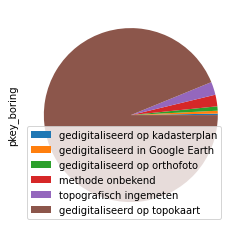

In [15]:
df_plot = df.groupby('methode_xy').count().pkey_boring.sort_values()

ax = df_plot.plot.pie(labels=None)

ax.set_aspect('equal')
ax.legend(loc=3, labels=df_plot.index)

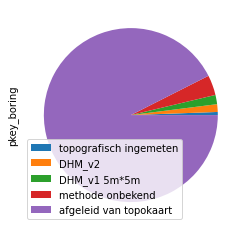

In [16]:
df_plot = df.groupby('methode_mv').count().pkey_boring.sort_values()

ax = df_plot.plot.pie(labels=None)
ax.set_aspect('equal')
ax.legend(loc=3, labels=df_plot.index)

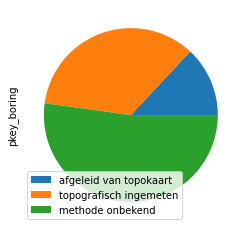

In [17]:
df_plot = df.groupby('methode_aanvangspeil').count().pkey_boring.sort_values()

ax = df_plot.plot.pie(labels=None)

ax.set_aspect('equal')
ax.legend(loc=3, labels=df_plot.index)

## Listing GxG for GrondwaterFilters

For some of our Grondwaterfilters precalculated groundwaterlevel statistics (GxG) are available next to the individual measurements (peilmetingen) themselves. These statistics give information about the average high, low and medium groundwater levels at that location.

They can be obtained by defining a new subtype for the GrondwaterFilter type:

In [18]:
from pydov.types.fields import XmlField, XsdType
from pydov.types.abstract import AbstractDovSubType
from pydov.types.grondwaterfilter import GrondwaterFilter


class Gxg(AbstractDovSubType):
    
    rootpath = './/filtermeting/gxg'

    fields = [
        XmlField(name='gxg_jaar',
                 source_xpath='/jaar',
                 definition='jaar (hydrologisch jaar voor lg3 en hg3, kalenderjaar voor vg3)',
                 datatype='integer'),
        XmlField(name='gxg_hg3',
                 source_xpath='/hg3',
                 definition='gemiddelde van de drie hoogste grondwaterstanden in een hydrologisch '
                            'jaar (1 april t/m 31 maart) bij een meetfrequentie van tweemaal per maand',
                 datatype='float'),
        XmlField(name='gxg_lg3',
                 source_xpath='/lg3',
                 definition='gemiddelde van de drie laagste grondwaterstanden in een hydrologisch jaar '
                            '(1 april t/m 31 maart) bij een meetfrequentie van tweemaal per maand',
                 datatype='float'),
        XmlField(name='gxg_vg3',
                 source_xpath='/vg3',
                 definition='gemiddelde van de grondwaterstanden op 14 maart, 28 maart en 14 april in '
                            'een bepaald kalenderjaar',
                 datatype='float')
    ]


class GrondwaterFilterGxg(GrondwaterFilter):
    subtypes = [Gxg]

In [19]:
from pydov.search.grondwaterfilter import GrondwaterFilterSearch
from owslib.fes import PropertyIsEqualTo

fs = GrondwaterFilterSearch(objecttype=GrondwaterFilterGxg)

In [20]:
fs.get_fields()['gxg_vg3']

{'name': 'gxg_vg3',
 'type': 'float',
 'definition': 'gemiddelde van de grondwaterstanden op 14 maart, 28 maart en 14 april in een bepaald kalenderjaar',
 'notnull': False,
 'query': False,
 'cost': 10}

In [21]:
df = fs.search(
    query=PropertyIsEqualTo('pkey_filter', 'https://www.dov.vlaanderen.be/data/filter/1999-009146')
)

[000/001]c


In [22]:
df.head()

,pkey_filter,pkey_grondwaterlocatie,gw_id,filternummer,filtertype,x,y,start_grondwaterlocatie_mtaw,mv_mtaw,gemeente,meetnet_code,aquifer_code,grondwaterlichaam_code,regime,diepte_onderkant_filter,lengte_filter,gxg_jaar,gxg_hg3,gxg_lg3,gxg_vg3
0,https://www.dov.vlaanderen.be/data/filter/1999...,https://www.dov.vlaanderen.be/data/put/2018-00...,HOSP063,1,peilfilter,26878.0,199250.0,4.25,4.25,De Panne,9,0120,NaN,onbekend,1.69,0.75,2000,NaN,NaN,3.99
1,https://www.dov.vlaanderen.be/data/filter/1999...,https://www.dov.vlaanderen.be/data/put/2018-00...,HOSP063,1,peilfilter,26878.0,199250.0,4.25,4.25,De Panne,9,0120,NaN,onbekend,1.69,0.75,2001,NaN,NaN,4.14
2,https://www.dov.vlaanderen.be/data/filter/1999...,https://www.dov.vlaanderen.be/data/put/2018-00...,HOSP063,1,peilfilter,26878.0,199250.0,4.25,4.25,De Panne,9,0120,NaN,onbekend,1.69,0.75,2002,4.29,3.51,4.17
3,https://www.dov.vlaanderen.be/data/filter/1999...,https://www.dov.vlaanderen.be/data/put/2018-00...,HOSP063,1,peilfilter,26878.0,199250.0,4.25,4.25,De Panne,9,0120,NaN,onbekend,1.69,0.75,2003,4.10,2.82,4.04
4,https://www.dov.vlaanderen.be/data/filter/1999...,https://www.dov.vlaanderen.be/data/put/2018-00...,HOSP063,1,peilfilter,26878.0,199250.0,4.25,4.25,De Panne,9,0120,NaN,onbekend,1.69,0.75,2004,3.84,2.95,3.91


## Adding color to the Borehole dataframe

The default dataframe of the Boring datatype contains information about the 'boormethode' as its subtype. However, in the DOV database there is information about the observed color of the soil in the various depth intervals available as well. We can access this data in pydov by defining a new subtype 'Kleur':

In [23]:
from pydov.types.abstract import AbstractDovSubType
from pydov.types.boring import Boring

class Kleur(AbstractDovSubType):
    
    rootpath = './/boring/details/kleur'

    fields = [
        XmlField(name='diepte_kleur_van',
                 source_xpath='/van',
                 definition='Bovenkant van de laag met een bepaalde bekisting, in meter.',
                 datatype='float'),
        XmlField(name='diepte_kleur_tot',
                 source_xpath='/tot',
                 definition='Onderkant van de laag met een bepaalde bekisting, in meter.',
                 datatype='float'),
        XmlField(name='kleur',
                 source_xpath='/kleur',
                 definition='Grondkleur voor het diepte-interval',
                 datatype='string')
    ]


class BoringKleur(Boring):
    subtypes = [Kleur]

In [24]:
from pydov.search.boring import BoringSearch
from owslib.fes import PropertyIsEqualTo

bs = BoringSearch(objecttype=BoringKleur)

In [25]:
bs.get_fields()['kleur']

{'name': 'kleur',
 'type': 'string',
 'definition': 'Grondkleur voor het diepte-interval',
 'notnull': False,
 'query': False,
 'cost': 10}

In [26]:
df = bs.search(
    query=PropertyIsEqualTo('pkey_boring', 'https://www.dov.vlaanderen.be/data/boring/2004-103984'),
    return_fields=('pkey_boring', 'boornummer', 'diepte_kleur_van', 'diepte_kleur_tot', 'kleur')
)

[000/001]c


In [27]:
df.head()

,pkey_boring,boornummer,diepte_kleur_van,diepte_kleur_tot,kleur
0,https://www.dov.vlaanderen.be/data/boring/2004...,GEO-04/169-BNo-B1,0.0,1.3,grijszwart
1,https://www.dov.vlaanderen.be/data/boring/2004...,GEO-04/169-BNo-B1,1.3,2.0,geel
2,https://www.dov.vlaanderen.be/data/boring/2004...,GEO-04/169-BNo-B1,2.0,3.2,grijszwart
3,https://www.dov.vlaanderen.be/data/boring/2004...,GEO-04/169-BNo-B1,3.2,3.5,grijszwart
4,https://www.dov.vlaanderen.be/data/boring/2004...,GEO-04/169-BNo-B1,3.5,6.3,grijsgroen
